In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

csv_dataset = 'Dataset Initializing/Variant Results Stripped.csv'
dataset = pd.read_csv(csv_dataset)
vectors = pd.DataFrame()
Ref_Alt_Dict = {'A':0, 'T':1, 'C':2, 'G':3}

In [2]:
#initializing the max value of the raw scores
RawScore_max = max(max(dataset['RawScore_A']),
max(dataset['RawScore_C']),
max(dataset['RawScore_T']),
max(dataset['RawScore_G']))

#initializing vectors
for index in range(dataset.shape[0]):
    vectors.loc[index, "RawScore_A"] = 1/(1+math.exp(-1*float(dataset.loc[index, "RawScore_A"])/RawScore_max))
    vectors.loc[index, "RawScore_T"] = 1/(1+math.exp(-1*float(dataset.loc[index, "RawScore_T"])/RawScore_max))
    vectors.loc[index, "RawScore_C"] = 1/(1+math.exp(-1*float(dataset.loc[index, "RawScore_C"])/RawScore_max))
    vectors.loc[index, "RawScore_G"] = 1/(1+math.exp(-1*float(dataset.loc[index, "RawScore_G"])/RawScore_max))
    if str(dataset.loc[index, "Phenotype"]) == 'nan':
        vectors.loc[index, "Label"] = 0
    else:
        vectors.loc[index, "Label"] = 1
    vectors.loc[index, "Control"] = str(dataset.loc[index, "Chromosome"]) + '.' +str(dataset.loc[index, "NTPosition"]) + '.' +dataset.loc[index, "NTChange"]

vectors.head()

,RawScore_A,RawScore_T,RawScore_C,RawScore_G,Label,Control
0,0.564738,0.577325,0.500000,0.580218,1.0,19.13506221.C>A
1,0.588046,0.587968,0.576281,0.500000,1.0,19.13506220.G>A
2,0.583085,0.573855,0.574739,0.500000,1.0,19.13506218.G>A
3,0.583085,0.573855,0.574739,0.500000,1.0,19.13506218.G>C
4,0.570248,0.569068,0.500000,0.567532,0.0,19.13506211.C>A


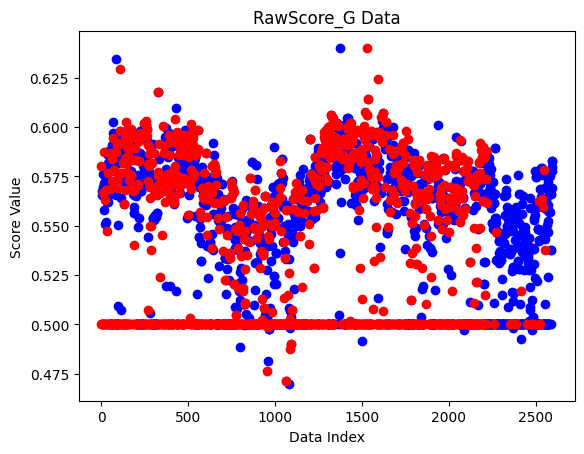

In [4]:
#data visualizing
column = 'RawScore_G'
pos = np.array([[vectors[column].index[int(disease[0])], vectors[column][int(disease[0])]] for disease in enumerate(vectors['Label']) if disease[1]])
neg = np.array([[vectors[column].index[int(disease[0])], vectors[column][int(disease[0])]] for disease in enumerate(vectors['Label']) if not(disease[1])])


plt1 = plt.scatter([int(i) for i in neg.T[0]], [float(i) for i in neg.T[1]], c='b')
plt1 = plt.scatter([int(i) for i in pos.T[0]], [float(i) for i in pos.T[1]], c='r')
plt.title(column + " Data")
plt.xlabel("Data Index")
plt.ylabel("Score Value")

plt.show(plt1)


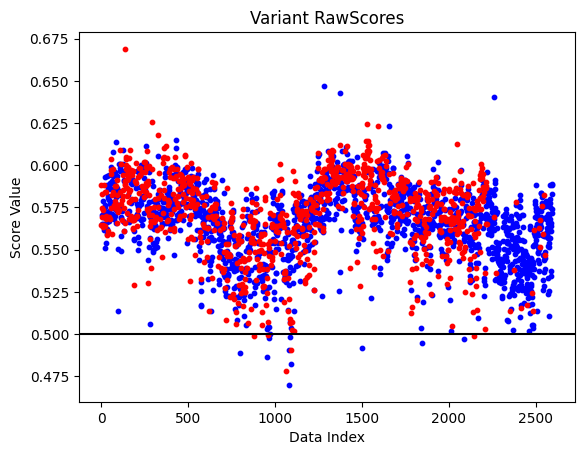

In [24]:
#variant data visualizing
net_Alt_vector = np.array([[index, vectors[vectors.columns[Ref_Alt_Dict[vectors['Control'][index][-1]]]][index]] for index in range(vectors.shape[0])])
pos_Alt_vector = np.array([[index, vectors[vectors.columns[Ref_Alt_Dict[vectors['Control'][index][-1]]]][index]] for index in range(vectors.shape[0]) if vectors['Label'][index]])
neg_Alt_vector = np.array([[index, vectors[vectors.columns[Ref_Alt_Dict[vectors['Control'][index][-1]]]][index]] for index in range(vectors.shape[0]) if not(vectors['Label'][index])])
Neg_values = [vectors['Control'][index] for index in range(neg_Alt_vector.shape[1]) if neg_Alt_vector[1][index] < 0.5]

pos_Alt_vector = pos_Alt_vector.T
neg_Alt_vector = neg_Alt_vector.T

# plt2 = plt.scatter(Alt_vector[0], Alt_vector[1], s=10)
# plt2 = plt.axline((0, 0.5), (Alt_vector[0][-1], 0.5), c='r')
# plt.show(plt2)

plt.scatter(neg_Alt_vector[0],neg_Alt_vector[1], c='b', s=10)
plt.scatter(pos_Alt_vector[0],pos_Alt_vector[1], c='r', s=10)
plt.axline((0, 0.5), (pos_Alt_vector[0][-1], 0.5), c='black')
plt.title("Variant RawScores")
plt.xlabel("Data Index")
plt.ylabel("Score Value")
plt.show()

In [13]:
"""
- plots of variant only vs label,
- try one of these models:
- SVM(RBF)
- XGBoost
- Ridge
- LASSO
"""

(2597, 6)

#### Training Testing Vector Initializing
Without Data Redistributing

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef

X = vectors[['RawScore_A', 'RawScore_T', 'RawScore_C', 'RawScore_G']]
Y = vectors['Label']
test_vector_size = 0.3

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_vector_size, random_state = 32)


## SVC Model Initializing

In [22]:
from sklearn.svm import SVC

kernels = ['rbf']
for kernel in kernels:
    svm_model = SVC(kernel=kernel, probability=True, random_state=32)
    svm_model.fit(X_train, Y_train)
    
    train_score = svm_model.score(X_train, Y_train)
    test_score = svm_model.score(X_test, Y_test)
    print(f'{kernel.capitalize()} SVM - Training Accuracy: {train_score:.2f}')
    print(f'{kernel.capitalize()} SVM - Test Accuracy: {test_score:.2f}')
    
    Y_pred_test = svm_model.predict(X_test)
    mcc = matthews_corrcoef(Y_test, Y_pred_test)
    print(f"MCC for Test subset: {mcc:.3f}")



Rbf SVM - Training Accuracy: 0.66
Rbf SVM - Test Accuracy: 0.65
MCC for Test subset: 0.160



## XGBoost Model Initializing

In [6]:
import xgboost as xgb

xgb_model = xgb.XGBRFClassifier(random_state=32)
xgb_model.fit(X_train, Y_train)

train_score = xgb_model.score(X_train, Y_train)
test_score = xgb_model.score(X_test, Y_test)
print(f'XGBoost Random Forest - Training Accuracy: {train_score:.2f}')
print(f'XGBoost Random Forest - Test Accuracy: {test_score:.2f}')

Y_pred_test = xgb_model.predict(X_test)
mcc = matthews_corrcoef(Y_test, Y_pred_test)
print(f"XGBoost Random Forest - MCC: {mcc:.3f}")

print("\nHyperparameters used in the XGBoost Random Forest model:")
for param, value in xgb_model.get_params().items():
    if value is not None:
        print(f'{param}: {value}')
    

XGBoost Random Forest - Training Accuracy: 0.73
XGBoost Random Forest - Test Accuracy: 0.64
XGBoost Random Forest - MCC: 0.135

Hyperparameters used in the XGBoost Random Forest model:
colsample_bynode: 0.8
learning_rate: 1.0
reg_lambda: 1e-05
subsample: 0.8
objective: binary:logistic
enable_categorical: False
missing: nan
random_state: 32



## Ridge Model Initializing

In [7]:
from sklearn.linear_model import RidgeClassifier
# Initialize the Ridge classifier
ridge_model = RidgeClassifier(random_state=123)

# Train the Ridge model
ridge_model.fit(X_train, Y_train)

# Evaluate the model
train_score = ridge_model.score(X_train, Y_train)
test_score = ridge_model.score(X_test, Y_test)
print(f'Ridge Regression - Training Accuracy: {train_score:.2f}')
print(f'Ridge Regression - Test Accuracy: {test_score:.2f}')

# Calculate Matthews Correlation Coefficient (MCC)
Y_pred_test = ridge_model.predict(X_test)
mcc = matthews_corrcoef(Y_test, Y_pred_test)
print(f"Ridge Regression - MCC: {mcc:.3f}")


Ridge Regression - Training Accuracy: 0.64
Ridge Regression - Test Accuracy: 0.63
Ridge Regression - MCC: -0.005



## Lasso Model Initializing

In [8]:
from sklearn.linear_model import LogisticRegression
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=123)

# Train the Lasso model
lasso_model.fit(X_train, Y_train)

# Evaluate the model
train_score = lasso_model.score(X_train, Y_train)
test_score = lasso_model.score(X_test, Y_test)
print(f'Lasso Regression - Training Accuracy: {train_score:.2f}')
print(f'Lasso Regression - Test Accuracy: {test_score:.2f}')

# Calculate Matthews Correlation Coefficient (MCC)
Y_pred_test = lasso_model.predict(X_test)
mcc = matthews_corrcoef(Y_test, Y_pred_test)
print(f"Lasso Regression - MCC: {mcc:.3f}")


Lasso Regression - Training Accuracy: 0.64
Lasso Regression - Test Accuracy: 0.63
Lasso Regression - MCC: 0.000
